In [1]:
import matplotlib.pyplot as plt
import sys
import os

sys.path.append('/usr/local/lib/python3.7/site-packages/')
 
from rdkit import Chem
from rdkit.Chem import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import RDConfig
from rdkit import rdBase
from rdkit.Chem.Draw import IPythonConsole

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool, cv
from tqdm import tqdm
# from sklearn.ensemble import RandomForestRegressor
# from boruta import BorutaPy

%matplotlib inline

# Prepare dataset

In [6]:
fasta_phys_chem_ki_df = pd.read_csv('../data/fasta-smiles-ki/unique_fasta_ki_phys-chem_descriptors.csv')
fasta_pbm_ki_df = pd.read_csv('../data/fasta-smiles-ki/unique_fasta_ki_pbm_descriptors.csv')

fasta_phys_chem_ic50_df = pd.read_csv('../data/fasta-smiles-ic50/unique_fasta_ic50_phys-chem_descriptors-ic50.csv')
fasta_pbm_ic50_df = pd.read_csv('../data/fasta-smiles-ic50/unique_fasta_ic50_pbm_descriptors-ic50.csv')

fasta_smiles_ki_df = pd.read_csv('../data/fasta-smiles-ki/fasta-smiles-ki-master.csv')
fasta_smiles_ki_df['FASTA'] = fasta_smiles_ki_df['FASTA'].apply(lambda x: x.upper())

fasta_smiles_ic50_df = pd.read_csv('../data/fasta-smiles-ic50/fasta-smiles-ic50-master.csv')
fasta_smiles_ic50_df['FASTA'] = fasta_smiles_ic50_df['FASTA'].apply(lambda x: x.upper())

In [7]:
fasta_smiles_ki_df.head()

FASTA  \
0  PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...   
1  PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...   
2  PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...   
3  PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...   
4  PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...   

                                              SMILES   Ki (nM)  
0      COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1 -0.619789  
1  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn... -0.602060  
2  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=... -0.387216  
3  OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@... -0.096910  
4  OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H... -0.004365

In [8]:
fasta_smiles_ki_df.shape

(351889, 3)

In [9]:
fasta_smiles_ic50_df.shape

(935752, 3)

In [10]:
fasta_smiles_ki_df.isna().sum()

FASTA      0
SMILES     0
Ki (nM)    0
dtype: int64

In [11]:
fasta_smiles_ic50_df.isna().sum()

FASTA        0
SMILES       0
IC50 (nM)    0
dtype: int64

In [59]:
# def convert(row):
#     try:
#         ki = row.strip().replace('<', '').replace('>', '')
#         return np.log10(float(ki))
#     except Exception as e:
#         print(e)
#         return np.nan

# ki_df['Ki (nM)'] = ki_df['Ki (nM)'].apply(convert)
# ki_df = ki_df.replace([np.inf, -np.inf], np.nan).dropna()
# ki_df.columns = ['FASTA', 'Ligand SMILES', 'Ki (nM)']
# ki_df.head()

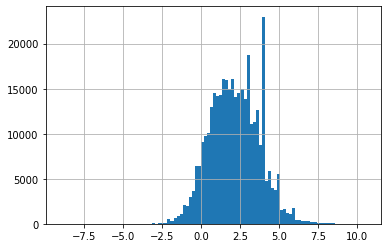

In [12]:
fasta_smiles_ki_df['Ki (nM)'].hist(bins=100)

In [13]:
fasta_smiles_ic50_df['IC50 (nM)'].hist(bins=100)

In [49]:
joined_ki = fasta_smiles_ki_df.join(fasta_phys_chem_ki_df.set_index('FASTA'), on='FASTA')
joined_ki = joined_ki.join(fasta_pbm_ki_df.set_index('FASTA'), on='FASTA')
joined_ki.head()

FASTA  \
0  PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...   
1  PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...   
2  PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...   
3  PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...   
4  PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...   

                                              SMILES   Ki (nM)   CV0   CV1  \
0      COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1 -0.619789  3.03  4.04   
1  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(C\C=C\c2cn... -0.602060  3.03  4.04   
2  O[C@@H]1[C@@H](O)[C@@H](Cc2ccccc2)N(CC2CC2)C(=... -0.387216  3.03  4.04   
3  OCCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@... -0.096910  3.03  4.04   
4  OCCCCCN1[C@H](Cc2ccccc2)[C@H](O)[C@@H](O)[C@@H... -0.004365  3.03  4.04   

    CV2   CV3   CV4   CV5   CV6  ...  _HydrophobicityD2001  \
0  3.03  4.04  2.02  4.04  6.06  ...                  1.01   
1  3.03  4.04  2.02  4.04  6.06  ...                  1.01   
2  3.03  4.04  2.02  4.04  6.06  ...                  1.01   
3  3.03  4.04  2.02  4.04  6.06  ...                  1.01   
4  3.03  4.04  2.02  4.04  6.06  ...                  1.01   

   _HydrophobicityD2025  _HydrophobicityD2050  _HydrophobicityD2075  \
0                26.263                48.485                73.737   
1                26.263                48.485                73.737   
2                26.263                48.485                73.737   
3                26.263                48.485                73.737   
4                26.263                48.485                73.737   

   _HydrophobicityD2100  _HydrophobicityD3001  _HydrophobicityD3025  \
0                 96.97                  3.03                23.232   
1                 96.97                  3.03                23.232   
2                 96.97                  3.03                23.232   
3                 96.97                  3.03                23.232   
4                 96.97                  3.03                23.232   

   _HydrophobicityD3050  _HydrophobicityD3075  _HydrophobicityD3100  
0                53.535                76.768                 100.0  
1                53.535                76.768                 100.0  
2                53.535                76.768                 100.0  
3                53.535                76.768                 100.0  
4                53.535                76.768                 100.0  

[5 rows x 241 columns]

In [48]:
joined_ic50 = fasta_smiles_ic50_df.join(fasta_phys_chem_ic50_df.set_index('FASTA'), on='FASTA')
joined_ic50 = joined_ic50.join(fasta_pbm_ic50_df.set_index('FASTA'), on='FASTA')
joined_ic50.head()

FASTA  \
0  MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...   
1  MAALRQPQVAELLAEARRAFREEFGAEPELAVSAPGRVNLIGEHTD...   
2  PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...   
3  PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...   
4  PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...   

                                              SMILES  IC50 (nM)    CV0   CV1  \
0  Cc1nc(CN2CCN(CC2)c2c(Cl)cnc3[nH]c(nc23)-c2cn(C...   4.698970   3.98  4.37   
1  O=C1CCCC2=C1C1(CCS(=O)(=O)C1)N=C(Nc1nc3ccccc3o...   3.824575  12.24  7.91   
2  CC(C)[C@H](NC(C)=O)C(=O)N[C@@H](Cc1ccccc1)[C@@...   0.929419   3.03  4.04   
3  CCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1)[...   2.247973   3.03  4.04   
4  COCCOC(=O)N[C@@H](C(C)C)C(=O)N[C@@H](Cc1ccccc1...   2.214844   3.03  4.04   

    CV2   CV3   CV4   CV5   CV6  ...  _HydrophobicityD2001  \
0  3.58  5.17  1.39  6.16  2.98  ...                 0.398   
1  1.28  3.32  2.04  7.65  5.10  ...                 0.510   
2  4.04  4.04  2.02  4.04  6.06  ...                 1.010   
3  4.04  4.04  2.02  4.04  6.06  ...                 1.010   
4  4.04  4.04  2.02  4.04  6.06  ...                 1.010   

   _HydrophobicityD2025  _HydrophobicityD2050  _HydrophobicityD2075  \
0                20.477                45.129                73.559   
1                26.276                46.684                77.551   
2                26.263                49.495                74.747   
3                26.263                49.495                74.747   
4                26.263                49.495                74.747   

   _HydrophobicityD2100  _HydrophobicityD3001  _HydrophobicityD3025  \
0               100.000                 0.199                22.465   
1                98.724                 0.255                23.469   
2                96.970                 3.030                23.232   
3                96.970                 3.030                23.232   
4                96.970                 3.030                23.232   

   _HydrophobicityD3050  _HydrophobicityD3075  _HydrophobicityD3100  
0                46.918                73.360                99.404  
1                48.214                71.939               100.000  
2                53.535                76.768               100.000  
3                53.535                76.768               100.000  
4                53.535                76.768               100.000  

[5 rows x 241 columns]

In [16]:
def get_ECFP(row):
    try:
        m = Chem.MolFromSmiles(row)
        fp = AllChem.GetMorganFingerprintAsBitVect(m,2,invariants=[1]*m.GetNumAtoms())
        array = np.zeros((0, ), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, array)
        return array
    except Exception as e:
        print(e)
#         return np.nan
        empty = np.empty(2048)
        empty[:] = np.nan
        return empty

In [31]:
ecfp4_ki_df = pd.Series(joined_ki['SMILES'].unique()).apply(get_ECFP)

RDKit ERROR: [13:29:23] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 15 16
RDKit ERROR: 
RDKit ERROR: [13:29:23] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 16
RDKit ERROR: 
RDKit ERROR: [13:29:23] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 15 16
RDKit ERROR: 
RDKit ERROR: [13:29:23] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [13:29:23] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 14 15 16
RDKit ERROR: 
RDKit ERROR: [13:29:23] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 31
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:23] Explicit valence for atom # 0 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:23] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13 17 18 19 30 31 32
RDKit ERROR: 
RDKit ERROR: [13:29:23] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13 16 17 18 28 29 30
RDKit ERROR: 
RDKit ERROR: [13:29:23] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13 16 17 18 29 30 31
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:24] Explicit valence for atom # 29 N, 4, is greater than permitted
RDKit ERROR: [13:29:24] Explicit valence for atom # 30 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:25] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:29:25] Explicit valence for atom # 1 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:26] Explicit valence for atom # 66 N, 4, is greater than permitted
RDKit ERROR: [13:29:26] Explicit valence for atom # 64 N, 4, is greater than permitted
RDKit ERROR: [13:29:26] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [13:29:26] Explicit valence for atom # 27 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:26] Explicit valence for atom # 22 N, 4, is greater than permitted
RDKit ERROR: [13:29:26] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [13:29:26] Explicit valence for atom # 21 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:27] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [13:29:27] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [13:29:27] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [13:29:27] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [13:29:27] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [13:29:27] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [13:29:27] Explicit valence for atom # 33 N, 4, is greater than permitted
RDKit ERROR: [13:29:27] Explicit valence for atom # 31 N, 4, is greater than permitted
RDKit ERROR: [13:29:27] Explicit valence for atom # 30 N, 4, is greater than permitted
RDKit ERROR: [13:29:27] Explicit valence for atom # 24 N, 4, is greater than permitted
RDKit ERROR: [13:29:27] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [13:29:27] Explicit valence fo

'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object ha

RDKit ERROR: [13:29:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 16
RDKit ERROR: 
RDKit ERROR: [13:29:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 16
RDKit ERROR: 
RDKit ERROR: [13:29:28] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
RDKit ERROR: 
RDKit ERROR: [13:29:28] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
RDKit ERROR: 
RDKit ERROR: [13:29:28] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
RDKit ERROR: 
RDKit ERROR: [13:29:28] Can't kekulize mol.  Unkekulized atoms: 10 12 13 14 15
RDKit ERROR: 
RDKit ERROR: [13:29:28] Can't kekulize mol.  Unkekulized atoms: 11 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [13:29:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 18 20
RDKit ERROR: 
RDKit ERROR: [13:29:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 19 21
RDKit ERROR: 
RDKit ERROR: [13:29:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 18 20
RDKit ERROR: 
RDKit ERROR: [13:29:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 19 21
RDKit ERR

'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object ha

RDKit ERROR: [13:29:29] Explicit valence for atom # 9 N, 4, is greater than permitted
RDKit ERROR: [13:29:29] Explicit valence for atom # 10 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:31] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [13:29:31] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [13:29:31] Explicit valence for atom # 13 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:31] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 26
RDKit ERROR: 
RDKit ERROR: [13:29:31] Can't kekulize mol.  Unkekulized atoms: 8 9 11 12 13
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:32] Can't kekulize mol.  Unkekulized atoms: 13 14 18
RDKit ERROR: 
RDKit ERROR: [13:29:32] Can't kekulize mol.  Unkekulized atoms: 3 20 24
RDKit ERROR: 
RDKit ERROR: [13:29:32] Can't kekulize mol.  Unkekulized atoms: 1 2 24
RDKit ERROR: 
RDKit ERROR: [13:29:32] Can't kekulize mol.  Unkekulized atoms: 1 2 23
RDKit ERROR: 
RDKit ERROR: [13:29:32] Can't kekulize mol.  Unkekulized atoms: 17 18 22
RDKit ERROR: 
RDKit ERROR: [13:29:32] Can't kekulize mol.  Unkekulized atoms: 15 16 20
RDKit ERROR: 
RDKit ERROR: [13:29:32] Can't kekulize mol.  Unkekulized atoms: 1 2 27
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:33] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:34] non-ring atom 14 marked aromatic


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:34] Explicit valence for atom # 26 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:35] Explicit valence for atom # 24 N, 4, is greater than permitted
RDKit ERROR: [13:29:35] Explicit valence for atom # 5 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [13:29:36] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
RDKit ERROR: 
RDKit ERROR: [13:29:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [13:29:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [13:29:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [13:29:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [13:29:36] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [13:29:36] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13 23 24
RDKit ERROR: 
RDKit ERROR: [13:29:36] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 34 35 36 37 38 44 45
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:37] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 28
RDKit ERROR: 
RDKit ERROR: [13:29:37] Explicit valence for atom # 18 N, 4, is greater than permitted
RDKit ERROR: [13:29:37] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [13:29:37] Explicit valence for atom # 23 N, 4, is greater than permitted
RDKit ERROR: [13:29:37] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [13:29:37] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [13:29:37] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [13:29:37] Explicit valence for atom # 27 N, 4, is greater than permitted
RDKit ERROR: [13:29:37] Explicit valence for atom # 6 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:37] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [13:29:37] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [13:29:37] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [13:29:37] Explicit valence for atom # 30 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:43] Explicit valence for atom # 1 B, 6, is greater than permitted
RDKit ERROR: [13:29:43] Explicit valence for atom # 1 B, 6, is greater than permitted
RDKit ERROR: [13:29:43] Explicit valence for atom # 1 C, 7, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:44] Explicit valence for atom # 19 C, 6, is greater than permitted
RDKit ERROR: [13:29:44] Explicit valence for atom # 4 C, 6, is greater than permitted
RDKit ERROR: [13:29:44] Explicit valence for atom # 8 C, 6, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:54] Explicit valence for atom # 6 O, 3, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:29:54] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [13:30:18] SMILES Parse Error: syntax error for input: 'O(C1C(O)C(O)C[N+H2]C1CO)C1C(O)C(O)C(O)C(CO)O1'
RDKit ERROR: [13:30:18] SMILES Parse Error: syntax error for input: 'O(C1C(O)C[N+H2]CC1CO)C1C(O)C(O)C(O)C(CO)O1'
RDKit ERROR: [13:30:18] SMILES Parse Error: syntax error for input: 'O=C(NC(C(=O)N1C(C(=O)NC(C=O)C(CC)C)CCC1)C(C)C)C([N+H3])C'
RDKit ERROR: [13:30:18] Explicit valence for atom # 0 B, 4, is greater than permitted
RDKit ERROR: [13:30:18] SMILES Parse Error: syntax error for input: 'O(C1C(O)C(O)C(OC2C(O)C(O)C(OC3C(O)C(O)C(O)OC3CO)OC2CO)OC1CO)C1C(O)C(O)C(OC2C(O)C(O)C(OC3C(O)C(O)C(OC4C(O)C(O)C([N+H2]C5C(O)C(O)C(O)C(CO)=C5)C(C)O4)C(CO)O3)C(CO)O2)C(CO)O1'
RDKit ERROR: [13:30:18] SMILES Parse Error: syntax error for input: 'O=C(NC1C(OC2C(O)C(O)C(O)C(CO)O2)C(O)C(CO)[N+H2]C1)C'
RDKit ERROR: [13:30:18] SMILES Parse Error: syntax error for input: 'O(C1C(CO)=CC([N+H2]C2C(O)C(O)C(OC3C(O)C(

'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:18] SMILES Parse Error: syntax error for input: 'O(C1C(O)C(O)C(O)CO1)C1C(O)C(O)C[N+H2]C1'
RDKit ERROR: [13:30:18] SMILES Parse Error: syntax error for input: 'O=C([O-])C(NC(=O)C([N+H3])CCCC[N+H3])CCCC[N+H3]'
RDKit ERROR: [13:30:18] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [13:30:18] SMILES Parse Error: syntax error for input: 'O(C1C(O)C(O)[N+H2]CC1CO)C1C(O)C(O)C(O)C(CO)O1'


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


In [32]:
ecfp4_ic50_df = pd.Series(joined_ic50['SMILES'].unique()).apply(get_ECFP)

RDKit ERROR: [13:30:21] non-ring atom 28 marked aromatic


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:22] Explicit valence for atom # 28 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:23] Explicit valence for atom # 12 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:26] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [13:30:26] Explicit valence for atom # 16 O, 3, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:35] Explicit valence for atom # 3 C, 5, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:36] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [13:30:36] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [13:30:36] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [13:30:36] Explicit valence for atom # 20 N, 4, is greater than permitted
RDKit ERROR: [13:30:36] Explicit valence for atom # 20 N, 4, is greater than permitted
RDKit ERROR: [13:30:36] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [13:30:36] Explicit valence for atom # 20 N, 4, is greater than permitted
RDKit ERROR: [13:30:36] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [13:30:36] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [13:30:36] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [13:30:36] Explicit valence for atom # 4 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:37] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:30:37] Explicit valence for atom # 1 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:39] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [13:30:39] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [13:30:39] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:40] Explicit valence for atom # 26 N, 4, is greater than permitted
RDKit ERROR: [13:30:40] Explicit valence for atom # 14 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:40] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:30:40] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [13:30:40] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [13:30:40] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [13:30:40] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [13:30:40] Explicit valence for atom # 18 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:42] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [13:30:42] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit ERROR: [13:30:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:30:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:30:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:30:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:30:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:30:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:30:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:30:42] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:30:42] Can't kekulize mol.  Unkekulized ato

'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object ha

RDKit ERROR: [13:30:44] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 35 36 37 38 39
RDKit ERROR: 
RDKit ERROR: [13:30:44] Can't kekulize mol.  Unkekulized atoms: 29 30 31 33 34
RDKit ERROR: 
RDKit ERROR: [13:30:45] Can't kekulize mol.  Unkekulized atoms: 17 18 19
RDKit ERROR: 
RDKit ERROR: [13:30:45] Can't kekulize mol.  Unkekulized atoms: 20 21 22
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:47] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [13:30:47] Can't kekulize mol.  Unkekulized atoms: 3 18 19 20 21 22 23
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:47] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:30:47] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:30:47] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [13:30:47] Explicit valence for atom # 0 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:48] Can't kekulize mol.  Unkekulized atoms: 3 4 5 7 8 10 12
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:48] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 19 20 21
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:49] Explicit valence for atom # 21 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:50] Explicit valence for atom # 21 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:51] Explicit valence for atom # 27 N, 4, is greater than permitted
RDKit ERROR: [13:30:51] Explicit valence for atom # 32 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:51] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 14
RDKit ERROR: 
RDKit ERROR: [13:30:51] Can't kekulize mol.  Unkekulized atoms: 6 7 8 10 11 13 14
RDKit ERROR: 
RDKit ERROR: [13:30:51] Can't kekulize mol.  Unkekulized atoms: 16 17 18 20 21 23 24
RDKit ERROR: 
RDKit ERROR: [13:30:51] Can't kekulize mol.  Unkekulized atoms: 13 14 15 17 18 20 21
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:53] Explicit valence for atom # 21 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:53] Explicit valence for atom # 3 N, 4, is greater than permitted
RDKit ERROR: [13:30:54] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:54] Explicit valence for atom # 1 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:54] Explicit valence for atom # 20 N, 4, is greater than permitted
RDKit ERROR: [13:30:54] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [13:30:55] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [13:30:55] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [13:30:55] Can't kekulize mol.  Unkekulized atoms: 22 23 25 26 28
RDKit ERROR: 
RDKit ERROR: [13:30:55] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
RDKit ERROR: 
RDKit ERROR: [13:30:55] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 25
RDKit ERROR: 
RDKit ERROR: [13:30:55] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:55] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [13:30:55] Can't kekulize mol.  Unkekulized atoms: 2 3 29
RDKit ERROR: 
RDKit ERROR: [13:30:55] Can't kekulize mol.  Unkekulized atoms: 2 3 29
RDKit ERROR: 
RDKit ERROR: [13:30:55] Can't kekulize mol.  Unkekulized atoms: 2 3 29
RDKit ERROR: 
RDKit ERROR: [13:30:55] Can't kekulize mol.  Unkekulized atoms: 2 3 29
RDKit ERROR: 
RDKit ERROR: [13:30:55] Can't kekulize mol.  Unkekulized atoms: 2 3 28
RDKit ERROR: 
RDKit ERROR: [13:30:55] Explicit valence for atom # 3 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:55] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
RDKit ERROR: 
RDKit ERROR: [13:30:55] Explicit valence for atom # 1 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:55] Explicit valence for atom # 4 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:56] Can't kekulize mol.  Unkekulized atoms: 7 8 15 16 17
RDKit ERROR: 
RDKit ERROR: [13:30:56] Can't kekulize mol.  Unkekulized atoms: 15 16 17 31 32 34 35 36 37
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:56] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [13:30:56] Explicit valence for atom # 1 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:57] Explicit valence for atom # 6 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:58] Explicit valence for atom # 32 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:30:58] Can't kekulize mol.  Unkekulized atoms: 18 20 21 22 23
RDKit ERROR: 
RDKit ERROR: [13:30:58] Can't kekulize mol.  Unkekulized atoms: 13 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [13:30:58] Can't kekulize mol.  Unkekulized atoms: 15 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [13:30:58] Can't kekulize mol.  Unkekulized atoms: 22 24 25 26 27
RDKit ERROR: 
RDKit ERROR: [13:30:59] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:00] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [13:31:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:31:00] Can't kekulize mol.  Unkekulized atoms: 1 2 3 14 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [13:31:00] Can't kekulize mol.  Unkekulized atoms: 1 2 5 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [13:31:00] Can't kekulize mol.  Unkekulized atoms: 10 11 12 20 21 22 23 24 25
RDKit ERROR: 
RDKit ERROR: [13:31:00] Can't kekulize mol.  Unkekulized atoms: 5 6 7 18 19 20 21 22 23
RDKit ERROR: 
RDKit ERROR: [13:31:00] Can't kekulize mol.  Unkekulized atoms: 7 8 9 20 21 22 23 24 25
RDKit ERROR: 
RDKit ERROR: [13:31:00] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [13:31:00] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 17 18
RDKit ERROR: 
RDKit ERROR: [13:31:00] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
R

'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:01] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 33
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:02] Explicit valence for atom # 18 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:03] Explicit valence for atom # 24 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:04] Explicit valence for atom # 16 N, 5, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:04] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [13:31:04] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [13:31:04] Explicit valence for atom # 13 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:05] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8 9 10 23 24
RDKit ERROR: 
RDKit ERROR: [13:31:05] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:05] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 18 19 20 21
RDKit ERROR: 
RDKit ERROR: [13:31:05] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 38 39 40
RDKit ERROR: 
RDKit ERROR: [13:31:05] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 38 39 40
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:07] Explicit valence for atom # 17 N, 4, is greater than permitted
RDKit ERROR: [13:31:07] Explicit valence for atom # 17 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:07] Explicit valence for atom # 21 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:08] Can't kekulize mol.  Unkekulized atoms: 26 27 28 30 31
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:09] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:10] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 13 14 15 16 19
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:10] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [13:31:10] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [13:31:10] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [13:31:10] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [13:31:10] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [13:31:10] Can't kekulize mol.  Unkekulized atoms: 8 9 10 19 20
RDKit ERROR: 
RDKit ERROR: [13:31:10] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [13:31:10] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24
RDKit ERROR: 
RDKit ERROR: [13:31:10] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23
RDKit ERROR: 
RDKit ERROR: [13:31:10] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25
RDKit ERROR: 
RDKit ERROR: [13:31:10] Can't kekulize mol.  Unkekulized atoms: 24 25 26 27 28
RDKit ERROR

'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object ha

RDKit ERROR: [13:31:11] Can't kekulize mol.  Unkekulized atoms: 14 15 16
RDKit ERROR: 
RDKit ERROR: [13:31:11] Can't kekulize mol.  Unkekulized atoms: 23 25 26
RDKit ERROR: 
RDKit ERROR: [13:31:11] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27
RDKit ERROR: 
RDKit ERROR: [13:31:11] Can't kekulize mol.  Unkekulized atoms: 7 8 9
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:11] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [13:31:11] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [13:31:11] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 22
RDKit ERROR: 
RDKit ERROR: [13:31:11] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [13:31:11] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [13:31:11] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 22
RDKit ERROR: 
RDKit ERROR: [13:31:11] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [13:31:11] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit ERROR: 
RDKit ERROR: [13:31:11] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit ERROR: 
RDKit ERROR: [13:31:11] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKit ERROR: 
RDKit ERROR: [13:31:11] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15
RDKi

'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:12] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 
RDKit ERROR: [13:31:12] Explicit valence for atom # 15 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:13] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:31:13] Explicit valence for atom # 14 N, 4, is greater than permitted
RDKit ERROR: [13:31:13] Explicit valence for atom # 6 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:14] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:31:14] Explicit valence for atom # 1 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:14] Explicit valence for atom # 3 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:16] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 27
RDKit ERROR: 
RDKit ERROR: [13:31:16] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:16] Explicit valence for atom # 8 N, 4, is greater than permitted
RDKit ERROR: [13:31:16] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 24
RDKit ERROR: 
RDKit ERROR: [13:31:16] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 24
RDKit ERROR: 
RDKit ERROR: [13:31:16] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 25
RDKit ERROR: 
RDKit ERROR: [13:31:16] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 24
RDKit ERROR: 
RDKit ERROR: [13:31:16] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 24
RDKit ERROR: 
RDKit ERROR: [13:31:16] Can't kekulize mol.  Unkekulized atoms: 19 20 22 23 24
RDKit ERROR: 
RDKit ERROR: [13:31:16] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 25
RDKit ERROR: 
RDKit ERROR: [13:31:16] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 25
RDKit ERROR: 
RDKit ERROR: [13:31:16] Can't kekulize mol.  Unkekulized atoms: 19 20 21 23 25
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:18] Explicit valence for atom # 41 N, 4, is greater than permitted
RDKit ERROR: [13:31:18] Explicit valence for atom # 8 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:19] Explicit valence for atom # 9 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:19] Explicit valence for atom # 27 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:20] Explicit valence for atom # 1 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:20] Explicit valence for atom # 20 N, 4, is greater than permitted
RDKit ERROR: [13:31:20] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [13:31:20] Explicit valence for atom # 20 N, 4, is greater than permitted
RDKit ERROR: [13:31:20] Explicit valence for atom # 24 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:21] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 
RDKit ERROR: [13:31:21] Can't kekulize mol.  Unkekulized atoms: 29 30 31 32 33
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:22] Explicit valence for atom # 1 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:22] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 18 19 20 21 22
RDKit ERROR: 
RDKit ERROR: [13:31:22] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 22 23 24 25 26
RDKit ERROR: 
RDKit ERROR: [13:31:22] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 22 23 24 25 26
RDKit ERROR: 
RDKit ERROR: [13:31:22] Can't kekulize mol.  Unkekulized atoms: 13 14 16 17 18 20 21 22 23
RDKit ERROR: 
RDKit ERROR: [13:31:22] Can't kekulize mol.  Unkekulized atoms: 13 14 16 17 18 20 21 22 23
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:23] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [13:31:23] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [13:31:23] Can't kekulize mol.  Unkekulized atoms: 18 19 23
RDKit ERROR: 
RDKit ERROR: [13:31:23] Can't kekulize mol.  Unkekulized atoms: 23 24 28
RDKit ERROR: 
RDKit ERROR: [13:31:23] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [13:31:23] Can't kekulize mol.  Unkekulized atoms: 20 21 25
RDKit ERROR: 
RDKit ERROR: [13:31:23] Can't kekulize mol.  Unkekulized atoms: 20 21 25
RDKit ERROR: 
RDKit ERROR: [13:31:23] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [13:31:23] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [13:31:23] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [13:31:23] Can't kekulize mol.  Unkekulized atoms: 1 4 6
RDKit ERROR: 
RDKit ERROR: [13:31:23] Can't kekulize mol.  Unkekulized atoms

'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object ha

RDKit ERROR: [13:31:25] Explicit valence for atom # 35 N, 4, is greater than permitted
RDKit ERROR: [13:31:25] Explicit valence for atom # 13 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:25] Explicit valence for atom # 22 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:26] Explicit valence for atom # 24 N, 4, is greater than permitted
RDKit ERROR: [13:31:26] Explicit valence for atom # 33 N, 4, is greater than permitted
RDKit ERROR: [13:31:26] Explicit valence for atom # 29 N, 4, is greater than permitted
RDKit ERROR: [13:31:26] Explicit valence for atom # 34 N, 4, is greater than permitted
RDKit ERROR: [13:31:26] Explicit valence for atom # 34 N, 4, is greater than permitted
RDKit ERROR: [13:31:26] Explicit valence for atom # 36 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:27] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [13:31:27] Explicit valence for atom # 3 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:27] non-ring atom 14 marked aromatic
RDKit ERROR: [13:31:27] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
RDKit ERROR: 
RDKit ERROR: [13:31:27] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
RDKit ERROR: 
RDKit ERROR: [13:31:27] Can't kekulize mol.  Unkekulized atoms: 33 34 36 37 39
RDKit ERROR: 
RDKit ERROR: [13:31:27] Can't kekulize mol.  Unkekulized atoms: 21 22 24 25 27
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:27] Can't kekulize mol.  Unkekulized atoms: 30 31 33 34 36
RDKit ERROR: 
RDKit ERROR: [13:31:27] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [13:31:27] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [13:31:27] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [13:31:27] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [13:31:27] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [13:31:27] Can't kekulize mol.  Unkekulized atoms: 18 19 21 22 24
RDKit ERROR: 
RDKit ERROR: [13:31:27] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 39
RDKit ERROR: 
RDKit ERROR: [13:31:27] Can't kekulize mol.  Unkekulized atoms: 12 13 15 16 18
RDKit ERROR: 
RDKit ERROR: [13:31:27] Can't kekulize mol.  Unkekulized atoms: 18 19 22 23 25
RDKit ERROR: 
RDKit ERROR: [13:31:27] Can't kekulize mol.  Unkekulized atoms: 19 20 22 2

'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object ha

RDKit ERROR: [13:31:29] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [13:31:29] Explicit valence for atom # 19 N, 4, is greater than permitted
RDKit ERROR: [13:31:29] Explicit valence for atom # 19 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:29] Explicit valence for atom # 8 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:30] Explicit valence for atom # 23 N, 4, is greater than permitted
RDKit ERROR: [13:31:30] Explicit valence for atom # 1 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:30] Can't kekulize mol.  Unkekulized atoms: 34 35 38
RDKit ERROR: 
RDKit ERROR: [13:31:30] Explicit valence for atom # 4 N, 4, is greater than permitted
RDKit ERROR: [13:31:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [13:31:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [13:31:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [13:31:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [13:31:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [13:31:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [13:31:30] Can't kekulize mol.  Unkekulized atoms: 1 3 6
RDKit ERROR: 
RDKit ERROR: [13:31:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [13:31:30] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [13:31:30] Explicit valence for atom # 1 N, 4, is greater 

'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:30] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [13:31:30] Explicit valence for atom # 3 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:31] Explicit valence for atom # 23 N, 4, is greater than permitted
RDKit ERROR: [13:31:31] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
RDKit ERROR: 
RDKit ERROR: [13:31:31] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
RDKit ERROR: 
RDKit ERROR: [13:31:31] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
RDKit ERROR: 
RDKit ERROR: [13:31:31] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 31
RDKit ERROR: 
RDKit ERROR: [13:31:31] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 31
RDKit ERROR: 
RDKit ERROR: [13:31:31] Can't kekulize mol.  Unkekulized atoms: 26 27 29 30 32
RDKit ERROR: 
RDKit ERROR: [13:31:31] Can't kekulize mol.  Unkekulized atoms: 24 25 27 28 30
RDKit ERROR: 
RDKit ERROR: [13:31:31] Can't kekulize mol.  Unkekulized atoms: 17 18 20 21 23
RDKit ERROR: 
RDKit ERROR: [13:31:31] Can't kekulize mol.  Unkekulized atoms: 25 26 28 29 31
RDKit ERROR: 
RDKit ERROR: [13:31:31] Can't kekulize mol.  Unkekulized atoms: 23 24 26 27 

'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object ha

RDKit ERROR: [13:31:32] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
RDKit ERROR: 
RDKit ERROR: [13:31:32] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
RDKit ERROR: 
RDKit ERROR: [13:31:32] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:33] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [13:31:33] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [13:31:33] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 
RDKit ERROR: [13:31:33] Can't kekulize mol.  Unkekulized atoms: 30 31 33
RDKit ERROR: 
RDKit ERROR: [13:31:33] Can't kekulize mol.  Unkekulized atoms: 24 25 27
RDKit ERROR: 
RDKit ERROR: [13:31:33] Can't kekulize mol.  Unkekulized atoms: 24 25 27
RDKit ERROR: 
RDKit ERROR: [13:31:33] Can't kekulize mol.  Unkekulized atoms: 1 2 6
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:34] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [13:31:34] Explicit valence for atom # 21 N, 4, is greater than permitted
RDKit ERROR: [13:31:34] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [13:31:34] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [13:31:34] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [13:31:34] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:35] Explicit valence for atom # 32 N, 4, is greater than permitted
RDKit ERROR: [13:31:35] Explicit valence for atom # 32 N, 4, is greater than permitted
RDKit ERROR: [13:31:35] Explicit valence for atom # 31 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:36] Can't kekulize mol.  Unkekulized atoms: 20 21 22 23 24 25 26 27 28
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:36] Explicit valence for atom # 24 N, 4, is greater than permitted
RDKit ERROR: [13:31:36] Explicit valence for atom # 24 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:36] Can't kekulize mol.  Unkekulized atoms: 5 6 8 9 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [13:31:37] Can't kekulize mol.  Unkekulized atoms: 2 3 5 36 38
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:37] Explicit valence for atom # 24 N, 4, is greater than permitted
RDKit ERROR: [13:31:37] Explicit valence for atom # 24 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:39] Explicit valence for atom # 12 N, 4, is greater than permitted
RDKit ERROR: [13:31:39] Explicit valence for atom # 16 Na, 2, is greater than permitted
RDKit ERROR: [13:31:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [13:31:39] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21 22 23 24 25
RDKit ERROR: 
RDKit ERROR: [13:31:39] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [13:31:39] Explicit valence for atom # 11 N, 4, is greater than permitted
RDKit ERROR: [13:31:39] Explicit valence for atom # 10 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:39] Can't kekulize mol.  Unkekulized atoms: 2 3 4 30 32
RDKit ERROR: 
RDKit ERROR: [13:31:39] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [13:31:39] Explicit valence for atom # 25 N, 4, is greater than permitted
RDKit ERROR: [13:31:39] Can't kekulize mol.  Unkekulized atoms: 16 17 19 20 21
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:40] Explicit valence for atom # 5 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:40] Can't kekulize mol.  Unkekulized atoms: 4 5 6 8 9 10 11 24 25
RDKit ERROR: 
RDKit ERROR: [13:31:40] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 28 29
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:40] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:41] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:31:41] Explicit valence for atom # 10 F, 4, is greater than permitted
RDKit ERROR: [13:31:41] Explicit valence for atom # 2 O, 3, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:41] Explicit valence for atom # 7 H, 2, is greater than permitted
RDKit ERROR: [13:31:41] Explicit valence for atom # 1 F, 2, is greater than permitted
RDKit ERROR: [13:31:41] Explicit valence for atom # 3 O, 3, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:42] Explicit valence for atom # 16 C, 5, is greater than permitted
RDKit ERROR: [13:31:42] Explicit valence for atom # 23 O, 3, is greater than permitted
RDKit ERROR: [13:31:42] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [13:31:42] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [13:31:42] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [13:31:42] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:31:42] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:31:42] Explicit valence for atom # 1 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:42] Explicit valence for atom # 5 H, 2, is greater than permitted
RDKit ERROR: [13:31:42] Explicit valence for atom # 5 H, 2, is greater than permitted
RDKit ERROR: [13:31:42] Explicit valence for atom # 5 H, 2, is greater than permitted
RDKit ERROR: [13:31:42] Explicit valence for atom # 3 H, 2, is greater than permitted
RDKit ERROR: [13:31:42] Explicit valence for atom # 1 F, 2, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:43] Can't kekulize mol.  Unkekulized atoms: 24 25 26 28 29
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:43] Explicit valence for atom # 2 H, 2, is greater than permitted
RDKit ERROR: [13:31:43] Explicit valence for atom # 19 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:43] Explicit valence for atom # 31 C, 6, is greater than permitted
RDKit ERROR: [13:31:44] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:31:44] Explicit valence for atom # 8 H, 2, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:44] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [13:31:44] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [13:31:44] Explicit valence for atom # 8 C, 5, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:44] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:31:44] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit ERROR: [13:31:44] Explicit valence for atom # 1 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:44] Explicit valence for atom # 36 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:45] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [13:31:45] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [13:31:45] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [13:31:45] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [13:31:45] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 21
RDKit ERROR: 
RDKit ERROR: [13:31:45] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 16
RDKit ERROR: 
RDKit ERROR: [13:31:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 26 27
RDKit ERROR: 
RDKit ERROR: [13:31:45] Explicit valence for atom # 2 N, 4, is greater than permitted
RDKit ERROR: [13:31:45] Explicit valence for atom # 5 N, 4, is greater than permitted
RDKit ERROR: [13:31:45] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [13:31:45] Can't kekulize mol.  Unkekulized atoms: 1 2 3 33 34
RDKit ERROR:

'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:45] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 26 27 28 29
RDKit ERROR: 


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:46] Explicit valence for atom # 16 N, 4, is greater than permitted
RDKit ERROR: [13:31:46] Explicit valence for atom # 29 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:46] Explicit valence for atom # 3 H, 2, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:46] Explicit valence for atom # 21 O, 3, is greater than permitted
RDKit ERROR: [13:31:46] Explicit valence for atom # 2 H, 2, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:47] Explicit valence for atom # 3 F, 2, is greater than permitted
RDKit ERROR: [13:31:47] Explicit valence for atom # 3 F, 2, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:47] Can't kekulize mol.  Unkekulized atoms: 8 10 12
RDKit ERROR: 
RDKit ERROR: [13:31:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 14 15 16 17 18 19
RDKit ERROR: 
RDKit ERROR: [13:31:47] Can't kekulize mol.  Unkekulized atoms: 11 12 13 14 15 16 17 18 19 20 21 24 25
RDKit ERROR: 
RDKit ERROR: [13:31:47] Explicit valence for atom # 1 Cl, 2, is greater than permitted
RDKit ERROR: [13:31:47] Explicit valence for atom # 25 C, 5, is greater than permitted
RDKit ERROR: [13:31:47] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:31:47] Can't kekulize mol.  Unkekulized atoms: 3 4 7 8 9
RDKit ERROR: 
RDKit ERROR: [13:31:47] Explicit valence for atom # 6 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:31:47] Explicit valence for atom # 1 N, 4, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:32:13] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [13:32:13] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [13:32:13] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [13:32:13] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [13:32:13] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [13:32:13] Explicit valence for atom # 7 B, 6, is greater than permitted
RDKit ERROR: [13:32:13] Explicit valence for atom # 7 C, 6, is greater than permitted
RDKit ERROR: [13:32:13] Explicit valence for atom # 7 C, 6, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


RDKit ERROR: [13:33:16] Explicit valence for atom # 11 C, 6, is greater than permitted


'NoneType' object has no attribute 'GetNumAtoms'


In [33]:
print(len(ecfp4_ki_df))
print(len(ecfp4_ic50_df))
print(len(joined_ki))
print(len(joined_ic50))

182580
577608
351889
935752


In [34]:
%%time
ecfp4_ki_df = pd.DataFrame.from_records(ecfp4_ki_df)
ecfp4_ki_df = ecfp4_ki_df.add_prefix('Ligand ECFP4 ')
ecfp4_ic50_df = pd.DataFrame.from_records(ecfp4_ic50_df)
ecfp4_ic50_df = ecfp4_ic50_df.add_prefix('Ligand ECFP4 ')

CPU times: user 11min 48s, sys: 24.5 s, total: 12min 12s
Wall time: 12min 51s


In [35]:
ecfp4_ki_df.isna().sum()

Ligand ECFP4 0       140
Ligand ECFP4 1       140
Ligand ECFP4 2       140
Ligand ECFP4 3       140
Ligand ECFP4 4       140
                    ... 
Ligand ECFP4 2043    140
Ligand ECFP4 2044    140
Ligand ECFP4 2045    140
Ligand ECFP4 2046    140
Ligand ECFP4 2047    140
Length: 2048, dtype: int64

In [36]:
ecfp4_ic50_df.isna().sum()

Ligand ECFP4 0       655
Ligand ECFP4 1       655
Ligand ECFP4 2       655
Ligand ECFP4 3       655
Ligand ECFP4 4       655
                    ... 
Ligand ECFP4 2043    655
Ligand ECFP4 2044    655
Ligand ECFP4 2045    655
Ligand ECFP4 2046    655
Ligand ECFP4 2047    655
Length: 2048, dtype: int64

In [37]:
ecfp4_ki_df = pd.concat([pd.Series(joined_ki['SMILES'].unique()), ecfp4_ki_df], axis=1)
ecfp4_ic50_df = pd.concat([pd.Series(joined_ic50['SMILES'].unique()), ecfp4_ic50_df], axis=1)

In [38]:
cols = ['SMILES']
cols.extend(ecfp4_ki_df.columns[1:])

In [39]:
ecfp4_ki_df.columns = cols
ecfp4_ic50_df.columns = cols

In [44]:
ecfp4_ki_df.head(1)

SMILES  Ligand ECFP4 0  \
0  COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1             0.0   

   Ligand ECFP4 1  Ligand ECFP4 2  Ligand ECFP4 3  Ligand ECFP4 4  \
0             1.0             0.0             0.0             0.0   

   Ligand ECFP4 5  Ligand ECFP4 6  Ligand ECFP4 7  Ligand ECFP4 8  ...  \
0             0.0             0.0             0.0             0.0  ...   

   Ligand ECFP4 2038  Ligand ECFP4 2039  Ligand ECFP4 2040  Ligand ECFP4 2041  \
0                0.0                0.0                0.0                0.0   

   Ligand ECFP4 2042  Ligand ECFP4 2043  Ligand ECFP4 2044  Ligand ECFP4 2045  \
0                0.0                0.0                0.0                0.0   

   Ligand ECFP4 2046  Ligand ECFP4 2047  
0                0.0                0.0  

[1 rows x 2049 columns]

In [45]:
ecfp4_ic50_df.head(1)

SMILES  Ligand ECFP4 0  \
0  Cc1nc(CN2CCN(CC2)c2c(Cl)cnc3[nH]c(nc23)-c2cn(C...             0.0   

   Ligand ECFP4 1  Ligand ECFP4 2  Ligand ECFP4 3  Ligand ECFP4 4  \
0             1.0             0.0             0.0             0.0   

   Ligand ECFP4 5  Ligand ECFP4 6  Ligand ECFP4 7  Ligand ECFP4 8  ...  \
0             0.0             0.0             0.0             0.0  ...   

   Ligand ECFP4 2038  Ligand ECFP4 2039  Ligand ECFP4 2040  Ligand ECFP4 2041  \
0                0.0                0.0                0.0                0.0   

   Ligand ECFP4 2042  Ligand ECFP4 2043  Ligand ECFP4 2044  Ligand ECFP4 2045  \
0                0.0                0.0                0.0                0.0   

   Ligand ECFP4 2046  Ligand ECFP4 2047  
0                0.0                0.0  

[1 rows x 2049 columns]

In [ ]:
joined_ki = joined_ki.join(ecfp4_ki_df.set_index('SMILES'), on='SMILES')
joined_ic50 = joined_ic50.join(ecfp4_ic50_df.set_index('SMILES'), on='SMILES')

In [53]:
joined_ki.head(1)

FASTA  \
0  PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMSLPGRWKPKM...   

                                          SMILES   Ki (nM)   CV0   CV1   CV2  \
0  COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1 -0.619789  3.03  4.04  3.03   

    CV3   CV4   CV5   CV6  ...  Ligand ECFP4 2038  Ligand ECFP4 2039  \
0  4.04  2.02  4.04  6.06  ...                0.0                0.0   

   Ligand ECFP4 2040  Ligand ECFP4 2041  Ligand ECFP4 2042  Ligand ECFP4 2043  \
0                0.0                0.0                0.0                0.0   

   Ligand ECFP4 2044  Ligand ECFP4 2045  Ligand ECFP4 2046  Ligand ECFP4 2047  
0                0.0                0.0                0.0                0.0  

[1 rows x 2289 columns]

In [54]:
joined_ic50.head(1)

FASTA  \
0  MALIPDLAMETWLLLAVSLVLLYLYGTHSHGLFKKLGIPGPTPLPF...   

                                              SMILES  IC50 (nM)   CV0   CV1  \
0  Cc1nc(CN2CCN(CC2)c2c(Cl)cnc3[nH]c(nc23)-c2cn(C...    4.69897  3.98  4.37   

    CV2   CV3   CV4   CV5   CV6  ...  Ligand ECFP4 2038  Ligand ECFP4 2039  \
0  3.58  5.17  1.39  6.16  2.98  ...                0.0                0.0   

   Ligand ECFP4 2040  Ligand ECFP4 2041  Ligand ECFP4 2042  Ligand ECFP4 2043  \
0                0.0                0.0                0.0                0.0   

   Ligand ECFP4 2044  Ligand ECFP4 2045  Ligand ECFP4 2046  Ligand ECFP4 2047  
0                0.0                0.0                0.0                0.0  

[1 rows x 2289 columns]

In [51]:
print(len(joined_ki))
print(len(joined_ic50))

351889

In [55]:
joined_ki.isna().sum()

FASTA                  0
SMILES                 0
Ki (nM)                0
CV0                   93
CV1                   93
                    ... 
Ligand ECFP4 2043    268
Ligand ECFP4 2044    268
Ligand ECFP4 2045    268
Ligand ECFP4 2046    268
Ligand ECFP4 2047    268
Length: 2289, dtype: int64

In [56]:
joined_ic50.isna().sum()

FASTA                   0
SMILES                  0
IC50 (nM)               0
CV0                  1616
CV1                  1616
                     ... 
Ligand ECFP4 2043    1148
Ligand ECFP4 2044    1148
Ligand ECFP4 2045    1148
Ligand ECFP4 2046    1148
Ligand ECFP4 2047    1148
Length: 2289, dtype: int64

In [57]:
joined_ki = joined_ki.dropna()
joined_ic50 = joined_ic50.dropna()

In [58]:
print(len(joined_ki))
print(len(joined_ic50))

351528
932988


In [59]:
%%time
joined_ki.to_csv('../data/fasta-smiles-ki/fasta_pbm_physchem_smiles_ecfp4_ki_with_strings_master.csv', index=None)
joined_ic50.to_csv('../data/fasta-smiles-ic50/fasta_pbm_physchem_smiles_ecfp4_ic50_with_strings_master.csv', index=None)

In [60]:
joined_ki = joined_ki.drop(columns=['FASTA', 'SMILES'])
joined_ic50 = joined_ic50.drop(columns=['FASTA', 'SMILES'])

In [61]:
%%time
joined_ki.to_csv('../data/fasta-smiles-ki/fasta_pbm_physchem_smiles_ecfp4_ki_master.csv', index=None)
joined_ic50.to_csv('../data/fasta-smiles-ic50/fasta_pbm_physchem_smiles_ecfp4_ic50_master.csv', index=None)

CPU times: user 23min 54s, sys: 9.54 s, total: 24min 4s
Wall time: 24min 11s


In [3]:
%%time
joined_ki = pd.read_csv('../data/fasta-smiles-ki/fasta_pbm_physchem_smiles_ecfp4_ki_master.csv')
joined_ic50 = pd.read_csv('../data/fasta-smiles-ic50/fasta_pbm_physchem_smiles_ecfp4_ic50_master.csv')

In [62]:
ecfp4_as_int_ki = joined_ki.filter(like='Ligand ECFP4').astype(np.int8)
ecfp4_as_int_ic50 = joined_ic50.filter(like='Ligand ECFP4').astype(np.int8)

In [63]:
joined_ki = joined_ki.drop(columns=joined_ki.filter(like='Ligand ECFP4').columns)
joined_ic50 = joined_ic50.drop(columns=joined_ic50.filter(like='Ligand ECFP4').columns)

In [64]:
joined_ki = pd.concat([joined_ki, ecfp4_as_int_ki], axis=1)
joined_ic50 = pd.concat([joined_ic50, ecfp4_as_int_ic50], axis=1)

In [65]:
joined_ki.dtypes

Ki (nM)              float64
CV0                  float64
CV1                  float64
CV2                  float64
CV3                  float64
                      ...   
Ligand ECFP4 2043       int8
Ligand ECFP4 2044       int8
Ligand ECFP4 2045       int8
Ligand ECFP4 2046       int8
Ligand ECFP4 2047       int8
Length: 2287, dtype: object

In [66]:
joined_ic50.dtypes

IC50 (nM)            float64
CV0                  float64
CV1                  float64
CV2                  float64
CV3                  float64
                      ...   
Ligand ECFP4 2043       int8
Ligand ECFP4 2044       int8
Ligand ECFP4 2045       int8
Ligand ECFP4 2046       int8
Ligand ECFP4 2047       int8
Length: 2287, dtype: object

# Train CatBoost - Ki

## Test run

In [67]:
X = joined_ki.drop(columns=['Ki (nM)'])
y = joined_ki['Ki (nM)']

In [68]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.9,
                                                    random_state=42,
                                                    shuffle=True)
print(len(x_train), len(x_test), len(y_train), len(y_test))

316375 35153 316375 35153


In [ ]:
col_len = len(X.columns)
categorical_features_indices = np.arange(col_len-2048,col_len)
model = CatBoostRegressor(
    l2_leaf_reg=5,
    learning_rate=0.1,
    early_stopping_rounds=200,
    iterations=100000,
    random_seed=42,
    task_type='GPU',
    verbose=False,
    loss_function='MAE',
    use_best_model=True,
    thread_count=-1,
#         od_type='Iter',
#         od_wait=100
)
model.fit(x_train,
          y_train,
          eval_set=(x_test, y_test),
          cat_features=categorical_features_indices)
model.best_score_

In [70]:
model.save_model('../models/ki_master_catboost_reg_mae_0.516_0.641')

## Crossvalidation

In [ ]:
col_len = len(X.columns)
categorical_features_indices = np.arange(col_len-2048,col_len)
model = CatBoostRegressor(
    l2_leaf_reg=3,
    learning_rate=0.1,
    early_stopping_rounds=100,
    iterations=10000,
    random_seed=42,
    task_type='GPU',
    verbose=False,
    loss_function='MAE',
    use_best_model=True,
    thread_count=-1,
#         od_type='Iter',
#         od_wait=100
)
cv_data = cv(
    Pool(X, y, cat_features=categorical_features_indices),
    model.get_params(),
    fold_count=10
)
print('Avg validation accuracy score: {:.2f}±{:.2f} on step {}'.format(
    np.mean(cv_data['test-MAE-mean']),
    cv_data['test-MAE-std'][np.mean(cv_data['test-MAE-mean'])],
    np.mean(cv_data['test-MAE-mean'])
))

## Tune hyperparameters

In [83]:
def objective(params):
    model = CatBoostRegressor(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=float(params['learning_rate']),
#         max_depth=int(params['max_depth']),
#         bagging_temperature=int(params['bagging_temperature']),
#         random_strength=int(params['random_strength']),
        early_stopping_rounds=100,
        iterations=10000,
#         eval_metric='Accuracy',
#         random_seed=42,
        task_type='GPU',
        verbose=False,
        loss_function='MAE',
        use_best_model=True,
        thread_count=-1,
#         od_type='Iter',
#         od_wait=100
    )
    
    cv_data = cv(
        Pool(X, y, cat_features=categorical_features_indices),
        model.get_params(),
        fold_count=10
    )
    return np.mean(cv_data['test-MAE-mean'])

In [ ]:
trials = hyperopt.Trials()
categorical_features_indices = [i for i in range(ki_x.shape[1])]
# categorical_features_indices = np.arange(0,2048)
X = ki_x
y = ki_y

params_space = {
    'learning_rate': hyperopt.hp.uniform('learning_rate', 0.1, 1),
    'max_depth': hyperopt.hp.quniform('max_depth', 3, 16, 1),
    'l2_leaf_reg': hyperopt.hp.uniform('l2_leaf_reg', 0, 50),
#     'colsample_bylevel': hyperopt.hp.uniform('colsample_bylevel', 0.5, 1.0),
#     'bagging_temperature': hyperopt.hp.uniform('bagging_temperature', 0.0, 100),
#     'random_strength': hyperopt.hp.uniform('random_strength', 0.0, 100),
#     'scale_pos_weight': hyperopt.hp.uniform('scale_pos_weight', 1.0, 16.0), # change 16.0 to n_negative / n_poistive
}

best = hyperopt.fmin(
    objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=50,
    trials=trials)

print(best)

# Inference

In [2]:
# load model
model = CatBoostRegressor()
model.load_model('../models/ki_master_catboost_reg_mae_0.516_0.641')
model.get_params()

{'loss_function': 'MAE',
 'use_best_model': True,
 'od_wait': 200,
 'verbose': 0,
 'iterations': 100000,
 'l2_leaf_reg': 7,
 'task_type': 'GPU',
 'random_seed': 42,
 'learning_rate': 0.1}

In [3]:
data_df = pd.read_csv('../data/2020-06_Enamine_screening_compounds_in-stock_SMILES.smiles', usecols=[0], sep='\s+')
data_df.shape

(2761292, 1)

In [4]:
train_df = pd.read_csv('../data/fasta-smiles-ki/fasta_pbm_physchem_smiles_ecfp4_ki_with_strings_master.csv')
train_df.shape

(351528, 2289)

In [5]:
ligand_cols = list(train_df.filter(like='Ligand ECFP4').columns)
ligand_cols.extend(['FASTA', 'SMILES', 'Ki (nM)'])

In [6]:
human_thrombin_fasta = 'MAHVRGLQLPGCLALAALCSLVHSQHVFLAPQQARSLLQRVRRANTFLEEVRKGNLERECVEETCSYEEAFEALESSTATDVFWAKYTACETARTPRDKLAACLEGNCAEGLGTNYRGHVNITRSGIECQLWRSRYPHKPEINSTTHPGADLQENFCRNPDSSTTGPWCYTTDPTVRRQECSIPVCGQDQVTVAMTPRSEGSSVNLSPPLEQCVPDRGQQYQGRLAVTTHGLPCLAWASAQAKALSKHQDFNSAVQLVENFCRNPDGDEEGVWCYVAGKPGDFGYCDLNYCEEAVEEETGDGLDEDSDRAIEGRTATSEYQTFFNPRTFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGRIVEGSDAEIGMSPWQVMLFRKSPQELLCGASLISDRWVLTAAHCLLYPPWDKNFTENDLLVRIGKHSRTRYERNIEKISMLEKIYIHPRYNWRENLDRDIALMKLKKPVAFSDYIHPVCLPDRETAASLLQAGYKGRVTGWGNLKETWTANVGKGQPSVLQVVNLPIVERPVCKDSTRIRITDNMFCAGYKPDEGKRGDACEGDSGGPFVMKSPFNNRWYQMGIVSWGEGCDRDGKYGFYTHVFRLKKWIQKVIDQFGE'


In [7]:
human_thrombin_fasta_features = train_df[train_df.FASTA == human_thrombin_fasta].drop(columns=ligand_cols)

In [8]:
human_thrombin_fasta_features

CV0   CV1   CV2   CV3   CV4  CV5   CV6   CV7   CV8   CV9  ...  \
4038    6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
4039    6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
4204    6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
4205    6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
4206    6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
...      ...   ...   ...   ...   ...  ...   ...   ...   ...   ...  ...   
343489  6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
343490  6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
343685  6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
343713  6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   
343872  6.75  7.07  4.02  5.63  4.18  8.2  4.18  7.88  2.09  3.54  ...   

        _HydrophobicityD2001  _HydrophobicityD2025  _HydrophobicityD2050  \
4038                   0.322                23.473                45.177   
4039                   0.322                23.473                45.177   
4204                   0.322                23.473                45.177   
4205                   0.322                23.473                45.177   
4206                   0.322                23.473                45.177   
...                      ...                   ...                   ...   
343489                 0.322                23.473                45.177   
343490                 0.322                23.473                45.177   
343685                 0.322                23.473                45.177   
343713                 0.322                23.473                45.177   
343872                 0.322                23.473                45.177   

        _HydrophobicityD2075  _HydrophobicityD2100  _HydrophobicityD3001  \
4038                  72.508                99.839                 0.161   
4039                  72.508                99.839                 0.161   
4204                  72.508                99.839                 0.161   
4205                  72.508                99.839                 0.161   
4206                  72.508                99.839                 0.161   
...                      ...                   ...                   ...   
343489                72.508                99.839                 0.161   
343490                72.508                99.839                 0.161   
343685                72.508                99.839                 0.161   
343713                72.508                99.839                 0.161   
343872                72.508                99.839                 0.161   

        _HydrophobicityD3025  _HydrophobicityD3050  _HydrophobicityD3075  \
4038                  25.241                54.823                76.206   
4039                  25.241                54.823                76.206   
4204                  25.241                54.823                76.206   
4205                  25.241                54.823                76.206   
4206                  25.241                54.823                76.206   
...                      ...                   ...                   ...   
343489                25.241                54.823                76.206   
343490                25.241                54.823                76.206   
343685                25.241                54.823                76.206   
343713                25.241                54.823                76.206   
343872                25.241                54.823                76.206   

        _HydrophobicityD3100  
4038                  99.678  
4039                  99.678  
4204                  99.678  
4205                  99.678  
4206                  99.678  
...                      ...  
343489                99.678  
343490                99.678  
343685                99.678  
343713                99.678  
343872                99.678  

[4117 ro

In [9]:
human_thrombin_fasta_features_list = human_thrombin_fasta_features.values[0].tolist()

In [10]:
def make_inference(row):
    try:
        m = Chem.MolFromSmiles(row)
        fp = AllChem.GetMorganFingerprintAsBitVect(m,2,invariants=[1]*m.GetNumAtoms())
        array = np.zeros((0, ), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, array)
        features = human_thrombin_fasta_features_list.copy()
        features = features +  array.tolist()
        pred = 10**model.predict(features)
        return pred
    except Exception as e:
        print(e)
        return np.nan

In [12]:
%%time

with open('../inference/2020-06_Enamine_screening_compounds_in-stock_SMILES.catboost.ki.master', 'w') as results:
    for index, row in tqdm(data_df.iterrows()):
        pred = make_inference(row.smiles)
        results.write("{}, {}\n".format(row.smiles, pred))

1158714it [3:27:12, 93.70it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

1224509it [3:38:58, 93.26it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

1352409it [4:01:49, 93.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_l

'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'
'NoneType' object has no attribute 'GetNumAtoms'


2607725it [7:45:44, 93.10it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2624017it [7:48:39, 94.19it/s]RDKit ERROR: [00:31:41] Explicit valence for atom # 7 N, 4, is greater than permitted
2624038it [7:48:39, 95.58it/s]

'NoneType' object has no attribute 'GetNumAtoms'


2633107it [7:50:16, 93.10it/s]RDKit ERROR: [00:33:18] Explicit valence for atom # 7 N, 4, is greater than permitted
2633118it [7:50:16, 96.20it/s]

'NoneType' object has no attribute 'GetNumAtoms'


2633788it [7:50:24, 91.85it/s]RDKit ERROR: [00:33:26] Explicit valence for atom # 11 N, 4, is greater than permitted
2633799it [7:50:24, 95.32it/s]

'NoneType' object has no attribute 'GetNumAtoms'


2636768it [7:50:55, 87.06it/s]RDKit ERROR: [00:33:57] Explicit valence for atom # 11 N, 4, is greater than permitted
2636789it [7:50:56, 92.25it/s]

'NoneType' object has no attribute 'GetNumAtoms'


2639196it [7:51:21, 93.02it/s]RDKit ERROR: [00:34:23] Explicit valence for atom # 8 N, 4, is greater than permitted
2639217it [7:51:22, 92.42it/s]

'NoneType' object has no attribute 'GetNumAtoms'


2640617it [7:51:37, 94.10it/s]RDKit ERROR: [00:34:39] Explicit valence for atom # 9 N, 4, is greater than permitted
2640638it [7:51:37, 95.86it/s]

'NoneType' object has no attribute 'GetNumAtoms'


2647237it [7:52:47, 94.31it/s]RDKit ERROR: [00:35:49] Explicit valence for atom # 7 N, 4, is greater than permitted
2647257it [7:52:48, 94.11it/s]

'NoneType' object has no attribute 'GetNumAtoms'


2649187it [7:53:08, 94.55it/s]RDKit ERROR: [00:36:10] Explicit valence for atom # 6 N, 4, is greater than permitted
2649198it [7:53:08, 97.36it/s]

'NoneType' object has no attribute 'GetNumAtoms'


2649988it [7:53:17, 93.17it/s]RDKit ERROR: [00:36:19] Explicit valence for atom # 12 N, 4, is greater than permitted
2650009it [7:53:17, 95.02it/s]

'NoneType' object has no attribute 'GetNumAtoms'


2650899it [7:53:27, 92.50it/s]RDKit ERROR: [00:36:29] Explicit valence for atom # 12 N, 4, is greater than permitted
2650920it [7:53:27, 93.52it/s]

'NoneType' object has no attribute 'GetNumAtoms'


2658529it [7:54:48, 90.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2710041it [8:04:00, 93.04it/s]RDKit ERROR: [00:47:02] Explicit valence for atom # 28 N, 4, is greater than permitted
2710062it [8:04:01, 95.40it/s]

'NoneType' object has no attribute 'GetNumAtoms'


2712032it [8:04:22, 92.70it/s]RDKit ERROR: [00:47:24] Explicit valence for atom # 5 N, 4, is greater than permitted
2712053it [8:04:22, 94.88it/s]

'NoneType' object has no attribute 'GetNumAtoms'


2761287it [8:13:10, 92.47it/s]RDKit ERROR: [00:56:12] Can't kekulize mol.  Unkekulized atoms: 14 15 16 17 18 19 20 21 22
RDKit ERROR: 
2761292it [8:13:10, 93.32it/s]

'NoneType' object has no attribute 'GetNumAtoms'
CPU times: user 12h 23min, sys: 1h 44min 1s, total: 14h 7min 1s
Wall time: 8h 13min 10s


# top 100

In [13]:
results_df = pd.read_csv('../inference/2020-06_Enamine_screening_compounds_in-stock_SMILES.catboost.ki.master',
                         header=None,
                         low_memory=False,
                         names=['SMILES', 'Ki (nM)'])

In [14]:
results_df.head()

SMILES              Ki (nM)
0               CCC1(NC(=O)N(Cc2ccccc2)C1=O)c1ccccc1    939.1498122685063
1        O=C(CSc1nnc(-c2cccs2)n1Cc1ccccc1)NCc1ccccc1    792.2324405868466
2                              CSc1nc2nc(C)cc(C)n2n1   3015.6195789550607
3                           Cc1cc(C)n2nc(SCC#N)nc2n1    431.0193648918625
4  FC(F)(F)c1cc(Cl)c(=O)n(CC(=O)N(Cc2ccccc2)Cc2cc...   193.92690547100247

In [15]:
results_df = results_df.dropna()

In [16]:
results_df['Ki (nM)'] = results_df['Ki (nM)'].astype(float)